
# Blood glucose assignment, Pierre Le Fevre

**CM1001, Assignment 1, Version 2, March 2022**

---



## Import data
Data files are stored in Google Drive to simplify loading *as* Google Colab was used for development.

The data files were then appended to one large dataframe.

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/ML_Data/Diabetes/data-1', delim_whitespace=True, names=['Date','Time', 'Code', 'Value'])

for i in range(2,71):
  data = data.append(pd.read_csv('/content/drive/MyDrive/ML_Data/Diabetes/data-' + str(i), delim_whitespace=True, names=['Date','Time', 'Code', 'Value']), ignore_index=True)

data

,Date,Time,Code,Value
0,04-21-1991,9:09,58,100
1,04-21-1991,9:09,33,9
2,04-21-1991,9:09,34,13
3,04-21-1991,17:08,62,119
4,04-21-1991,17:08,33,7
...,...,...,...,...
29325,05-09-1989,08:00,33,1.0
29326,05-09-1989,08:00,34,7.0
29327,05-10-1989,08:00,34,7.0
29328,05-11-1989,08:00,34,7.0


## Data cleaning

First, missing values were removed from the dataframe. (66 errors)

In [ ]:
#Remove incomplete rows
def missing_cols(df):
    '''prints out columns with its amount of missing values'''
    total = 0
    for col in df.columns:
        missing_vals = df[col].isnull().sum()
        total += missing_vals
        if missing_vals != 0:
            print(f"{col} => {df[col].isnull().sum()}")
    
    if total == 0:
        print("no missing values left")
            
missing_cols(data)

data = data.dropna()
missing_cols(data)

Value => 66
no missing values left


Dates were removed as according to the data codes, it seems like they are connected to time of day and not date.

In [ ]:
#Strip dates
data = data.drop(['Date'], axis=1)
data

,Time,Code,Value
0,9:09,58,100
1,9:09,33,9
2,9:09,34,13
3,17:08,62,119
4,17:08,33,7
...,...,...,...
29325,08:00,33,1.0
29326,08:00,34,7.0
29327,08:00,34,7.0
29328,08:00,34,7.0


The codes that are not measurements were removed as some of them seem to represent hours of applied insulin and not mg/litre of blood sugar.
The workout and meal codes were generally 0, and were also removed.

Minutes were also removed as they did not seem to have a discernable effect on R2 score.

(18015 removed)

In [ ]:
#Strip invalid codes
defined_codes = (58, 62, 60, 48, 57)
data = data[data.Code.isin(defined_codes)]

#Strip minutes from time
for index, row in data.iterrows():
  row.Time = int(row.Time.split(":")[0])

data

,Time,Code,Value
0,9,58,100
3,17,62,119
5,22,48,123
6,7,58,216
10,16,62,211
...,...,...,...
29314,12,60,151.0
29317,22,48,265.0
29318,8,58,248.0
29323,22,48,145.0


All values were casted to integers, and the rows that cannot be casted to ints were removed (For example "0Hi" and "0Lo")

(8 instances removed)

In [ ]:
# Remove all non integer values
def tryInt(val):
  try:
    int(val)
    return True
  except:
    return False

data = data[data["Value"].apply(tryInt)]

In [ ]:
# Cast all values to integers
for index, row in data.iterrows():
  row.Code = int(row.Code)
  row.Time = int(row.Time)
  row.Value = int(row.Value)

data

,Time,Code,Value
0,9,58,100
3,17,62,119
5,22,48,123
6,7,58,216
10,16,62,211
...,...,...,...
29314,12,60,151
29317,22,48,265
29318,8,58,248
29323,22,48,145


The hours were then validated to remove erraneous timestamps (lower than 0 or higher than 23), 316 removed

In [ ]:
# Remove all rows where hour is invalid
def tryTime(val):
  if(val < 23 and val >= 0):
    return True
  else:
    return False

data = data[data["Time"].apply(tryTime)]
data

,Time,Code,Value
0,9,58,100
3,17,62,119
5,22,48,123
6,7,58,216
10,16,62,211
...,...,...,...
29314,12,60,151
29317,22,48,265
29318,8,58,248
29323,22,48,145


Lists for x and y axes were generated


In [ ]:
# Generate x and y axes
y_axis = []
x_axis = []

for index, row in data.iterrows():
  if(row.Time < 23 and row.Time > 0 and row.Value > 0 and row.Value > 40):
    x_axis.append([row.Time, row.Code])
    y_axis.append(row.Value)
  else:
    data = data.drop(index)

## Model training

Many different types of regression models are available from Scikit. To find the most fitting model, the data was plotted. See pairplot below.

As seen in the code-value graph, the relation was very difficult to see. There dit not appear to be a clear direction for the data points.

,Time,Code,Value
0,9,58,100
3,17,62,119
5,22,48,123
6,7,58,216
10,16,62,211
...,...,...,...
29314,12,60,151
29317,22,48,265
29318,8,58,248
29323,22,48,145


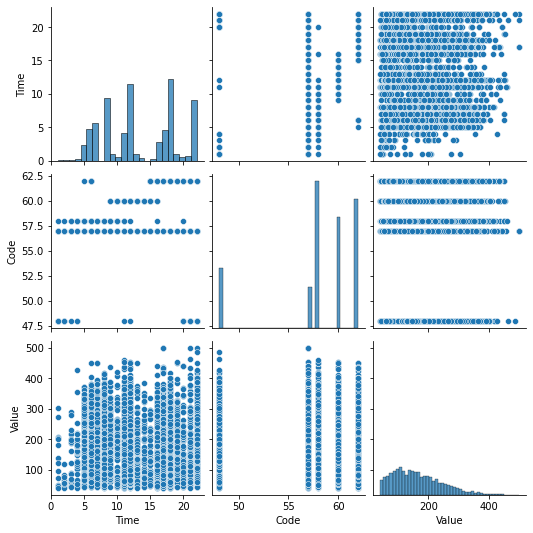

In [ ]:
sns.pairplot(data)
data

### Linear regression

Mean squared error: 6408.80
Coefficient of determination: 0.00720        1 is perfect score


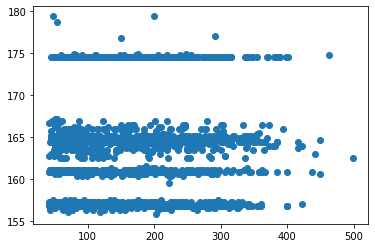

In [ ]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_axis, y_axis)

regr = linear_model.LinearRegression()

regr.fit(x_train, y_train)
y_pred = regr.predict(x_test)

print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Coefficient of determination: %.5f        1 is perfect score" % r2_score(y_test, y_pred))
plt.scatter(y_test, y_pred)
plt.show()

### Support Vector regression

Mean squared error: 6079.33
Coefficient of determination: -0.01358        1 is perfect score


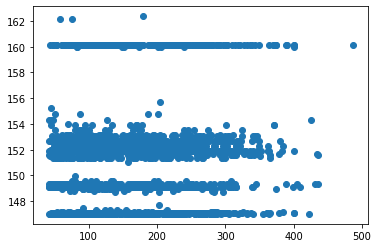

In [ ]:
from sklearn import svm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_axis, y_axis)

regr = svm.SVR()
regr.fit(x_train, y_train)
y_pred = regr.predict(x_test)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Coefficient of determination: %.5f        1 is perfect score" % r2_score(y_test, y_pred))
plt.scatter(y_test, y_pred)
plt.show()

### Polynomial (Linear regression)

Mean squared error: 6156.65
Coefficient of determination: 0.01309        1 is perfect score


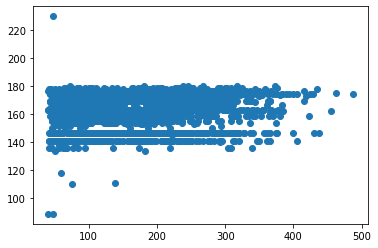

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, precision_score
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=4)
poly_features = poly.fit_transform(x_axis)

X_train, X_test, y_train, y_test = train_test_split(poly_features, y_axis, test_size=0.3, random_state=20)

poly_reg_model = linear_model.LinearRegression()
poly_reg_model.fit(X_train, y_train)

y_pred = poly_reg_model.predict(X_test)

print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Coefficient of determination: %.5f        1 is perfect score" % r2_score(y_test, y_pred))


plt.scatter(y_test, y_pred)
plt.show()

## Conclusion 

The tested models were Linear, SVR and Polynomial.

Purely based on R2 score, polynomial seems to be the way to go. I do think however that it is so low that the model cannot be used for much at all. Values returned appear to be aront 150-200 which seems to be, according to my limited research, the average blood glucose values for humans.

The model always seems to spit out the average Blood Glucose values for humans. My hypothesis is that the data is so spread out that "outliers" simply cannot be predicted since for each outlier, there are hundreds, if not thousands, of more average datapoints with these timestamps and codes.


In the real world, such a model would to little other than report the average blood glucose value for humans. Perhaps a classification model which could show whether a patient, from a set of measurements, has signs indicating diabetes would be more useful.

Ethically, since the data is anonymous and merged into a large file, and that there is no way to reach a particular data point from the prediction part, I do not think that there is much of a privacy problem.

One thing that might be important if a similar, but better performing, model was used for actual medical advice, it needs to be very careful about giving out diagnosis for diabetes considering the fact that it is quite an impacful diagnosnis to get.
A simple recommendation to visit a doctor could be a more safe route.

# Revisiting this problem



Coefficient of determination: 0.00711        1 is perfect score


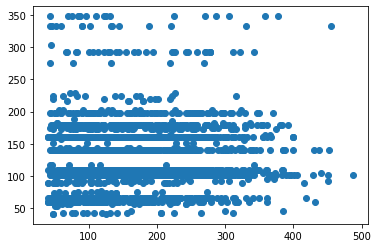

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(x_axis, y_axis)

clf = RandomForestClassifier().fit(X_train, y_train)

print("Coefficient of determination: %.5f        1 is perfect score" % clf.score(X_test, y_test))
y_pred = clf.predict(X_test)

plt.scatter(y_test, y_pred)
plt.show()

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
X_train, X_test, y_train, y_test = train_test_split(x_axis, y_axis)

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train, y_train)

print("Coefficient of determination: %.5f        1 is perfect score" % clf.score(X_test, y_test))

y_pred = clf.predict(X_test)
plt.scatter(y_test, y_pred)
plt.show()